In [1]:
#pip install tensorflow


In [2]:
#pip install keras

# Our task is to predict the letter giving the hand sign picture.
We don't have a specific question to choose which performance metric is better so we use all of them (including precision, accuracy, recall and f1-score).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from joblib import Parallel, delayed

from tensorflow.keras.preprocessing.image import ImageDataGenerator


from skimage.feature import hog
from skimage import exposure
from skimage.transform import rotate
from skimage import draw
%matplotlib inline

In [4]:
pre_train = pd.read_csv('sign_mnist_train.csv')
pre_test = pd.read_csv('sign_mnist_test.csv')

**TAKE A LOOK**

In [5]:
pre_train.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [6]:
#CHECK FOR NULL
print(pre_train.isnull().sum())
print(pre_test.isnull().sum())



label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


In [7]:
train_set, val_set = train_test_split(pre_train, test_size=0.3, stratify=pre_train["label"], random_state=42)

print("train shape", train_set.shape)
print("val shape", val_set.shape)


train shape (19218, 785)
val shape (8237, 785)


In [8]:
print(train_set["label"].value_counts().sort_index(ascending=True) *100 / len(train_set),)

label
0     4.100323
1     3.678843
2     4.167968
3     4.355292
4     3.486315
5     4.386513
6     3.970236
7     3.689250
8     4.230409
10    4.058695
11    4.521802
12    3.840150
13    4.193985
14    4.355292
15    3.965033
16    4.657092
17    4.714330
18    4.365699
19    4.318868
20    4.230409
21    3.939016
22    4.459361
23    4.240816
24    4.074305
Name: count, dtype: float64


In [9]:
train_set.max()

label        24
pixel1      255
pixel2      255
pixel3      255
pixel4      255
           ... 
pixel780    255
pixel781    255
pixel782    255
pixel783    255
pixel784    255
Length: 785, dtype: int64

 TRY TO USE SOME PREPROCERSSING TECHNIQUE

**PREPARE SOME FUNCTIONS TO SEE WHAT ARE THE IMAGES**

process_raw_file_into_2_label_histogram : the function has 2 assignments, hist FALSE = remove the label column of dataframe, hist TRUE = turn dataframe into pixel histogram of each image

In [10]:
def process_raw_file_into_histogram_and_label_or_dataset_and_label(filename, hist=False):
    # check filename or DataFrame
    if isinstance(filename, str):
        df = pd.read_csv(filename)
    elif isinstance(filename, pd.DataFrame):
        df = filename
    else:
        raise ValueError("Input must be a file path or a pandas DataFrame")

    # separate label
    labels = df['label'].values

    # process the value in df into histogram
    if hist:
        # number of rows from original
        row_quantity = df.shape[0]
        pixels = np.empty((row_quantity, 255))
        # because the maximum value we check is less than 256


        for i in range(row_quantity):
            temp = df.iloc[i].drop('label')

            # count unique False
            temp = temp.value_counts(sort=False)

            # make into histogram from 0 to 255,
            temp = temp.reindex(range(0, 256), fill_value=0)

            temp = temp.to_numpy()
            # assign value from temp to array pixels:
            pixels[i] = temp
    else:
        # hist is False, just drop the 'label' column
        pixels = df.drop(columns=['label']).values

    pixels = pixels.astype(np.float64)

    return pixels, labels


In [11]:
def show_first_n_images(pixels, labels, n, img_size=28):

    pixels_tmp = pixels.reshape(-1, img_size, img_size, 1)
    plt.figure(figsize=(18, int(n/3)))

    for i in range(n):
        plt.subplot((n - 1) // 6 + 1, 6, i + 1)  #6 columns for images
        plt.axis('off')
        plt.title(f'Label: {labels[i]}')
        plt.imshow(pixels_tmp[i, :, :, 0], cmap='gray')

    plt.show()



def show_images_by_condition(pixels, labels, chosen_label, img_size=28):
    # filter the pixels and labels for the chosen label
    filtered_pixels = pixels[labels == chosen_label]
    filtered_labels = labels[labels == chosen_label]

    # Choose 5 random indices
    n = 5
    random_indices = np.random.choice(filtered_pixels.shape[0], n, replace=False)
    filtered_pixels = filtered_pixels[random_indices].reshape(-1, img_size, img_size)
    filtered_labels = filtered_labels[random_indices]

    # Set up the subplot dimensions
    num_rows = (n - 1) // 6 + 1

    plt.figure(figsize=(18, num_rows * 3))

    for i in range(n):
        plt.subplot(num_rows, 6, i + 1)
        plt.axis('off')
        plt.title(f'Label: {filtered_labels[i]}')
        plt.imshow(filtered_pixels[i], cmap='gray')

    plt.show()


In [12]:
# read data from csv file
X_train, y_train = process_raw_file_into_histogram_and_label_or_dataset_and_label(train_set)
X_val, y_val = process_raw_file_into_histogram_and_label_or_dataset_and_label(val_set)
X_test, y_test = process_raw_file_into_histogram_and_label_or_dataset_and_label(pre_test)

# normalize data from 0 to 1 range
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255



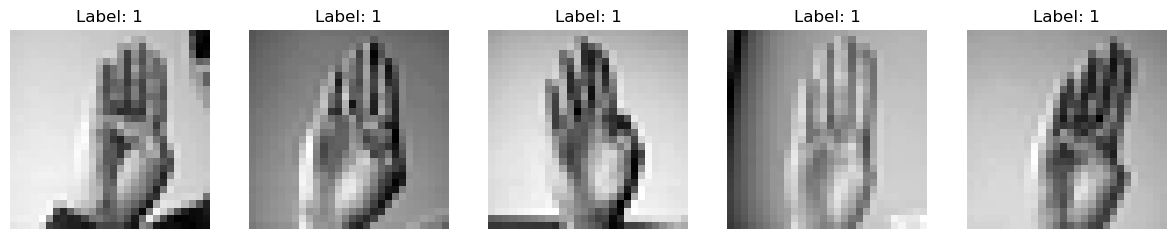

In [13]:
# visualize images
show_images_by_condition(X_train, y_train, chosen_label=1)


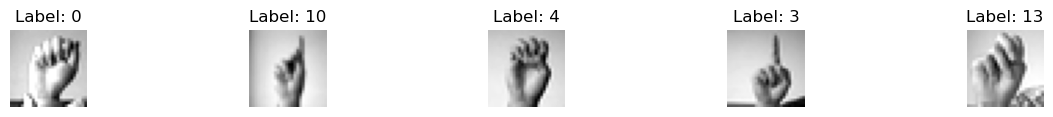

In [14]:
# visualize images
show_first_n_images(X_train, y_train, n=5)

**PERFORM HOG on the first instance by hand to know how it works**

In [15]:
example_img = X_train[0].reshape(28, 28) *255
example_label = y_train[0]


height, width = example_img.shape

# zero first
G_x_gradient = np.zeros((height, width))
G_y_gradient = np.zeros((height, width))

# G_x_gradient G_y_gradient for pixel
for i in range(1, height - 1): #we dont judge edge
    for j in range(1, width - 1):
        #G_x
        right_pixel = example_img[i, j + 1]
        left_pixel = example_img[i, j - 1]
        G_x_gradient[i, j] = right_pixel - left_pixel

        #G_y
        bottom_pixel = example_img[i + 1, j]
        top_pixel = example_img[i - 1, j]
        G_y_gradient[i, j] = bottom_pixel - top_pixel

In [16]:
print(example_img)
print(G_x_gradient)


[[213. 214. 215. 216. 218. 220. 220. 223. 222. 222. 221. 221. 221. 219.
  221. 219. 217. 217. 216. 215. 215. 215. 215. 213. 212. 211. 210. 210.]
 [212. 214. 217. 218. 219. 222. 221. 222. 222. 222. 223. 221. 221. 223.
  221. 218. 217. 220. 220. 217. 216. 216. 214. 213. 212. 211. 212. 211.]
 [213. 216. 218. 219. 221. 222. 222. 223. 223. 224. 223. 223. 223. 223.
  221. 222. 236. 210. 195. 220. 218. 217. 216. 214. 214. 213. 213. 212.]
 [215. 217. 219. 221. 222. 223. 223. 224. 225. 226. 227. 225. 223. 231.
  213. 236. 255. 220. 166. 172. 209. 188. 205. 219. 212. 216. 214. 212.]
 [216. 218. 220. 223. 223. 224. 225. 225. 226. 226. 228. 223. 243. 253.
  222. 243. 255. 224. 162. 169. 215. 180. 145. 190. 151. 197. 219. 214.]
 [217. 220. 222. 224. 226. 225. 227. 228. 227. 228. 230. 211. 255. 252.
  231. 240. 255. 226. 161. 235. 228. 169. 116. 158. 120. 195. 220. 214.]
 [218. 222. 223. 226. 228. 227. 229. 231. 223. 255. 255. 218. 255. 255.
  227. 222. 255. 230. 158. 206. 213. 151. 119. 156. 132. 2

In [17]:
magnitude = np.zeros_like(G_x_gradient)
orientation = np.zeros_like(G_x_gradient)

# magnitude and orientation pixel
for i in range(height):
    for j in range(width):
        magnitude[i, j] = np.sqrt(G_x_gradient[i, j]**2 + G_y_gradient[i, j]**2)
        orientation[i, j] = np.arctan2(G_y_gradient[i, j], G_x_gradient[i, j])* (180 / np.pi) % 180



In [18]:
#number of bins for the histogram
num_bins = 9
bin_width = 180 / num_bins

#histogram
histogram_pixel = np.zeros((28, 28, num_bins))


for i in range(1, height - 1):
    for j in range(1, width - 1):
        grad_mag = magnitude[i, j]
        grad_orient = orientation[i, j]

        # find the bins for gradient
        bin_lower = int(grad_orient // bin_width)
        bin_upper = (bin_lower + 1) % num_bins

        # compute the contribution for the bins
        contrib = grad_mag * ((grad_orient - (bin_lower * bin_width)) / bin_width)

        # add the contribution to the bins
        histogram_pixel[i, j, bin_lower] += grad_mag - contrib
        histogram_pixel[i, j, bin_upper] += contrib

# flatten
hog_feature_descriptor_pixel = histogram_pixel.flatten()

In [19]:
print(histogram_pixel[10][13])

[ 0.          0.          0.          0.          0.          0.
 22.36697203 26.55132721  0.        ]


In [20]:
import numpy as np

cell_size = 2
num_cells_x = 28 // cell_size
num_cells_y = 28 // cell_size
histogram_cell = np.zeros((num_cells_y, num_cells_x, 9))

#histograms for each cell
for i in range(num_cells_y):
    for j in range(num_cells_x):
        for y in range(cell_size):
            for x in range(cell_size):
                histogram_cell[i, j] += histogram_pixel[i * cell_size + y, j * cell_size + x]



In [21]:
print(len(histogram_cell))

14


In [22]:
# normalize gradients in 4×4 pixel (1 block) using overlap
block_size = 2  # each block is 2x2 cells = 4×4 pixel
num_blocks_x = num_cells_x - 1
num_blocks_y = num_cells_y - 1
normalized_histogram = np.zeros((num_blocks_y, num_blocks_x, block_size * block_size * 9))

for i in range(num_blocks_y):
    for j in range(num_blocks_x):
        # block_histogram by flattening the 2x2 cells = 4×4 pixel cell block
        block_histogram = histogram_cell[i:i+block_size, j:j+block_size].ravel()
        norm = np.linalg.norm(block_histogram)
        if norm != 0:
            normalized_histogram[i, j] = block_histogram / norm
normalized_histogram_flat = normalized_histogram.flatten()

In [23]:
print(len(normalized_histogram_flat))

6084


**HOG by package**

In [24]:
def get_hog(image):

    fd,hog_image=hog(image.reshape(28, 28),orientations=9,pixels_per_cell=(2,2),
                        cells_per_block=(2, 2),visualize=True,feature_vector=True)
    return fd

In [25]:
def get_hog_image(image):

    fd,hog_image=hog(image.reshape(28, 28),orientations=9,pixels_per_cell=(2,2),
                        cells_per_block=(2, 2),visualize=True,feature_vector=True)
    return hog_image

In [26]:
#already done and save
#hog_X_train = Parallel(n_jobs=-1)(delayed(get_hog)(img) for img in X_train)
#hog_X_test = Parallel(n_jobs=-1)(delayed(get_hog)(img) for img in X_test)

In [27]:
#already done and save
#np.save("data1/hog_features_train.npy", hog_X_train)
#np.save("data1/hog_features_test.npy", hog_X_test)

In [28]:
hog_X_train = np.load("hog_features_train.npy")
hog_X_test = np.load("hog_features_test.npy")

In [29]:
print(hog_X_train.shape)
print(hog_X_test.shape)

(19218, 6084)
(7172, 6084)


In [30]:
hog_X_train_pictures = np.array(Parallel(n_jobs=-1)(delayed(get_hog_image)(img) for img in X_train[:10]))

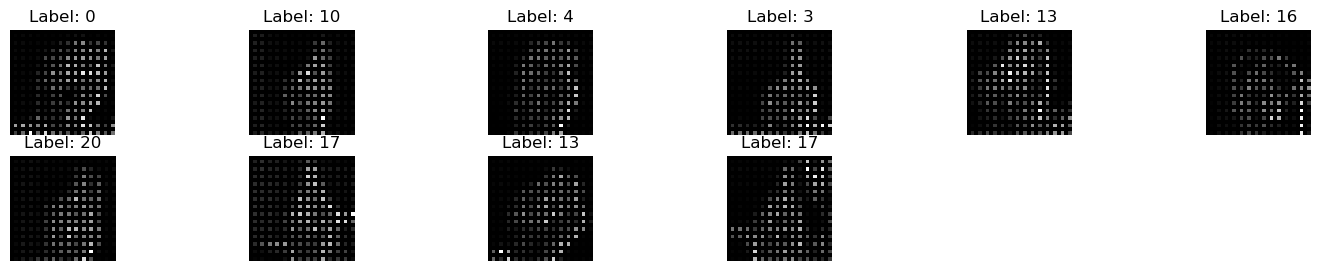

In [31]:
show_first_n_images(hog_X_train_pictures, y_train[:10], 10, img_size=28)

data augmentation

In [32]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)
datagen.fit(X_train.reshape(len(X_train), 28, 28, 1))


applying hog to the augmented data

In [33]:
from joblib import Parallel, delayed
num_cores = -1

def generate_augmented_features(datagen, X_train, y_train):

    # Generate augmented data
    for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=20000, shuffle=True):
        print(X_batch.shape)
        augmented_data = Parallel(n_jobs=-1)(delayed(get_hog)(img) for img in X_batch)
        augmented_labels = y_batch
        break


    return np.array(augmented_data), np.array(augmented_labels)

In [34]:
augmented_data, augmented_labels = generate_augmented_features(datagen, X_train.reshape(len(X_train), 28, 28, 1), y_train.reshape(len(X_train),))

(19218, 28, 28, 1)


In [35]:
#np.save("/content/drive/MyDrive/Felix Project/data/extend_hog_features_train.npy", augmented_data)
#np.save("/content/drive/MyDrive/Felix Project/data/extend_hog_features_test.npy", augmented_labels)

In [36]:
augmented_data = np.array(pd.read_csv("augmented_data.csv"))
augmented_labels = np.array(pd.read_csv("augmented_label.csv"))

In [37]:
print(augmented_data.shape)
print(augmented_labels.shape)

(19217, 784)
(19217, 1)


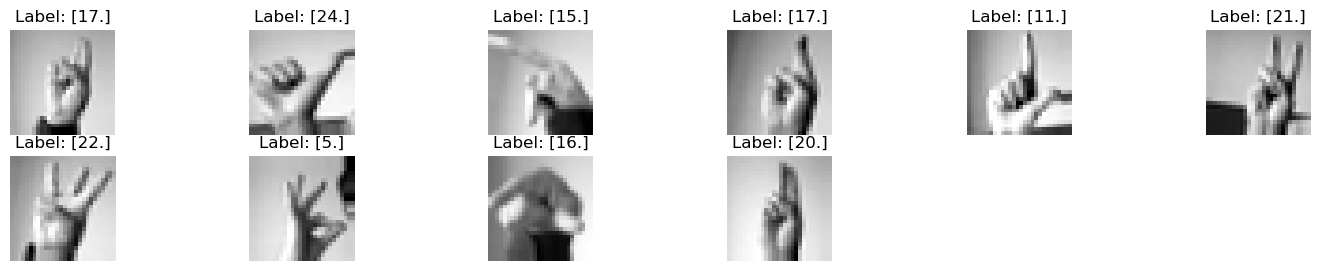

In [38]:
show_first_n_images(augmented_data, augmented_labels, 10, img_size=28)

In [39]:
augmented_data_hog = np.load("extend_hog_features_train.npy")
augmented_labels_hog = np.load("extend_hog_features_test.npy")
print(augmented_data_hog.shape)
print(augmented_labels_hog.shape)

(19218, 6084)
(19218,)


combine the augmented data to the original data

In [40]:
preprocessed_X_train = np.vstack((augmented_data_hog, hog_X_train))
extend_y_train = np.concatenate((augmented_labels_hog, y_train))

In [41]:
print(hog_X_train.shape)
print(y_train.shape)

(19218, 6084)
(19218,)


In [42]:
print(preprocessed_X_train.shape)
print(extend_y_train.shape)

(38436, 6084)
(38436,)


In [43]:
pca = PCA(n_components=50)
preprocessed_X_train=pca.fit_transform(preprocessed_X_train)

In [44]:
preprocessed_X_test = pca.transform(hog_X_test)

In [45]:
print(preprocessed_X_train.shape)
print(preprocessed_X_test.shape)

(38436, 50)
(7172, 50)


train model using preprocessed data set

In [46]:
model_knn1 = KNeighborsClassifier(n_neighbors=3)
model_knn1.fit(preprocessed_X_train, extend_y_train)

KNeighborsClassifier(n_neighbors=3)

In [47]:
predictions = model_knn1.predict(preprocessed_X_train)
print(classification_report(predictions, extend_y_train))
predictions = model_knn1.predict(preprocessed_X_test)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1587
           1       0.99      0.99      0.99      1416
           2       1.00      1.00      1.00      1602
           3       0.99      0.99      0.99      1670
           4       0.99      0.99      0.99      1339
           5       1.00      1.00      1.00      1688
           6       1.00      1.00      1.00      1526
           7       1.00      1.00      1.00      1418
           8       1.00      1.00      1.00      1626
          10       1.00      0.99      0.99      1567
          11       1.00      1.00      1.00      1736
          12       0.99      0.98      0.98      1484
          13       0.99      0.99      0.99      1604
          14       1.00      1.00      1.00      1673
          15       1.00      1.00      1.00      1525
          16       1.00      1.00      1.00      1790
          17       0.99      0.99      0.99      1814
          18       0.99    

In [48]:
model_logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100000)

# Train the model
model_logistic.fit(preprocessed_X_train, extend_y_train)

LogisticRegression(max_iter=100000, multi_class='multinomial')

In [49]:
predictions = model_logistic.predict(preprocessed_X_train)
print(classification_report(predictions, extend_y_train))
predictions = model_logistic.predict(preprocessed_X_test)
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1583
           1       0.84      0.85      0.84      1392
           2       0.91      0.91      0.91      1600
           3       0.79      0.79      0.79      1672
           4       0.79      0.85      0.82      1253
           5       0.87      0.86      0.86      1702
           6       0.86      0.87      0.86      1502
           7       0.86      0.85      0.86      1443
           8       0.79      0.78      0.78      1644
          10       0.77      0.75      0.76      1600
          11       0.86      0.85      0.85      1775
          12       0.70      0.72      0.71      1436
          13       0.69      0.73      0.71      1529
          14       0.84      0.85      0.84      1644
          15       0.92      0.91      0.92      1529
          16       0.91      0.88      0.89      1853
          17       0.74      0.72      0.73      1873
          18       0.74    

In [50]:
param_grid_SVM_rbf = {
    'gamma': [1, 0.1, 0.01, 0.001],  # gamma
}

# Initialize an SVM model
svm = SVC(kernel="rbf")

# Initialize the grid search with cross-validation
grid_search_SVM_rbf = GridSearchCV(estimator=svm, param_grid=param_grid_SVM_rbf, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the training data
grid_search_SVM_rbf.fit(preprocessed_X_train, extend_y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'gamma': [1, 0.1, 0.01, 0.001]}, scoring='accuracy',
             verbose=2)

In [53]:
print(len(predictions))

38436


In [54]:
print(grid_search_SVM_rbf.best_estimator_)
print(grid_search_SVM_rbf.best_score_)

predictions = grid_search_SVM_rbf.predict(preprocessed_X_train)
print(classification_report(predictions, extend_y_train))
predicionts_SVM_rbf = grid_search_SVM_rbf.predict(preprocessed_X_test)
print(classification_report(y_test, predicionts_SVM_rbf))

SVC(gamma=0.1)
0.9844160688877406
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1576
           1       1.00      1.00      1.00      1414
           2       1.00      1.00      1.00      1602
           3       1.00      1.00      1.00      1674
           4       1.00      1.00      1.00      1340
           5       1.00      1.00      1.00      1686
           6       1.00      1.00      1.00      1526
           7       1.00      1.00      1.00      1418
           8       1.00      1.00      1.00      1626
          10       1.00      1.00      1.00      1560
          11       1.00      1.00      1.00      1738
          12       1.00      1.00      1.00      1477
          13       1.00      1.00      1.00      1610
          14       1.00      1.00      1.00      1674
          15       1.00      1.00      1.00      1524
          16       1.00      1.00      1.00      1790
          17       1.00      1.00      1.00    

In [55]:
param_grid_SVM_poly = {
    'C': [0.1, 1, 10],          # Regularization parameter
    'degree': [2, 3, 4, 5,7], #degree
}

# Initialize an SVM model
svm = SVC(kernel="poly")

# Initialize the grid search with cross-validation
grid_search_SVM_poly = GridSearchCV(estimator=svm, param_grid=param_grid_SVM_poly, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the training data
grid_search_SVM_poly.fit(preprocessed_X_train, extend_y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=SVC(kernel='poly'), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4, 5, 7]},
             scoring='accuracy', verbose=2)

In [56]:
print(grid_search_SVM_poly.best_estimator_)
print(grid_search_SVM_poly.best_score_)

predictions = grid_search_SVM_poly.predict(preprocessed_X_train)
print(classification_report(predictions, extend_y_train))
predicionts_SVM_poly = grid_search_SVM_poly.predict(preprocessed_X_test)
print(classification_report(y_test, predicionts_SVM_poly))

SVC(C=10, kernel='poly')
0.9867836247177045
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1576
           1       1.00      1.00      1.00      1414
           2       1.00      1.00      1.00      1602
           3       1.00      1.00      1.00      1674
           4       1.00      1.00      1.00      1340
           5       1.00      1.00      1.00      1686
           6       1.00      1.00      1.00      1526
           7       1.00      1.00      1.00      1418
           8       1.00      1.00      1.00      1626
          10       1.00      1.00      1.00      1560
          11       1.00      1.00      1.00      1738
          12       1.00      1.00      1.00      1476
          13       1.00      1.00      1.00      1612
          14       1.00      1.00      1.00      1674
          15       1.00      1.00      1.00      1524
          16       1.00      1.00      1.00      1790
          17       1.00      1.00    

In [57]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(preprocessed_X_train, extend_y_train)


RandomForestClassifier(random_state=42)

In [58]:
predicionts = rf_classifier.predict(preprocessed_X_train)
print(classification_report(extend_y_train, predicionts))
predicionts = rf_classifier.predict(preprocessed_X_test)
print(classification_report(y_test, predicionts))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1576
           1       1.00      1.00      1.00      1414
           2       1.00      1.00      1.00      1602
           3       1.00      1.00      1.00      1674
           4       1.00      1.00      1.00      1340
           5       1.00      1.00      1.00      1686
           6       1.00      1.00      1.00      1526
           7       1.00      1.00      1.00      1418
           8       1.00      1.00      1.00      1626
          10       1.00      1.00      1.00      1560
          11       1.00      1.00      1.00      1738
          12       1.00      1.00      1.00      1476
          13       1.00      1.00      1.00      1612
          14       1.00      1.00      1.00      1674
          15       1.00      1.00      1.00      1524
          16       1.00      1.00      1.00      1790
          17       1.00      1.00      1.00      1812
          18       1.00    

**As we can see , after do some preprocessing technique ( hog and data augmentation ) the model learn better and can predcict well in the unseen data . By combining HOG with data augmentation, the model learns to recognize the essential features of objects while being exposed to a wide variety of images.**